<a href="https://colab.research.google.com/github/gldkhoward/PPE-Yolov5/blob/main/A2_Journal_13939715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author: Luke Howard  
# Student ID: 13939715
# ML Algorithm: Custom YOLOv5 (Object Detection)  
# Project Title: Detecting Safety Equipment in High-Risk Construction Zones

---

## Introduction

This project involves building a machine learning system to detect whether individuals on a construction site are wearing the required safety equipment. The system uses computer vision to monitor camera footage in real-time, identifying people and determining if they are wearing items like safety vests, hardhats, and safety glasses. This project aims to improve safety compliance on high-risk sites, ensuring personnel adhere to safety regulations.

As a bit of a preamble to my choice of project I have recently started a role with a construction managerment software company in the UK. They are expanding and exploring practical applications of ML and Ai for use in construction and will hopefully persue this research further.

The project implements **YOLOv5**, a real-time object detection model, to classify and detect safety equipment. Roboflow is used to source and annotate the dataset, consisting of images of workers with and without safety equipment.






---

## Step 1: Importing Dependencies and Environment Setup

In this section we import all relevant project depoendencies and setup the environment with essential data from google drive and github



In [ ]:
import torch
from matplotlib import pyplot as plt
import cv2  # For video processing
import pandas as pd
import numpy as np
from PIL import Image
import os
import glob

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA is available. Training will utilize the GPU for faster computation.")
else:
    print("Warning: CUDA is not available. Training will be performed on the CPU, which will significantly increase training time.")



### Github Project Clone
Below we clone the github code which contains the custom model code and additional functionality for the PPE checker

In [ ]:
!git clone https://github.com/gldkhoward/PPE-Yolov5.git

### Google Drive Mount
I utalised google drive for storing experiments and test data allowing me to go back and experiment with different models during testing and model evaluation.

*Note this will not work for other users of the notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Step 2: Dataset Exploration and Preparation

### Preamble
In this section we initially explore what importing images from a Roboflow dataset looks like. The images have been sourced from multiple projects to give a robust collection of images and labels

### Dataset Description
- **Source**: Roboflow (custom-annotated images for safety gear detection)
- **Classes**:
  1. Person
  2. Hardhat
  3. Safety Vest
  4. Safety Glasses
  5. Boots
  6. Gloves

### Dataset Loading
Roboflow provides the images in YOLOv5 format, which we load into our Colab environment for training and validation.

In [3]:
# Install required packages
!pip install roboflow
!pip install wget

import os
import wget
import zipfile

# Function to automate downloading, unzipping, and setting up the dataset
def download_and_setup_dataset(download_link, extract_path='/content/ML-31005-6'):
    # Create the folder if it doesn't exist
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    # Download the dataset zip file
    zip_file_path = os.path.join(extract_path, 'dataset.zip')
    print("Downloading dataset...")
    wget.download(download_link, zip_file_path)

    # Unzipping the dataset
    print("\nUnzipping dataset...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Deleting the zip file after extraction
    os.remove(zip_file_path)
    print("Dataset setup complete.")

# Roboflow API access (optional and quicker)
try:
    from roboflow import Roboflow
    rf = Roboflow(api_key="nuhuhuh")
    # Download the dataset using the API
    project = rf.workspace("lukehowarduts").project("ml-31005")
    version = project.version(6)  # Latest version of data with hotfixes to missing classes
    dataset = version.download("yolov5")
    print("Dataset downloaded via API.")
except Exception as e:
    print(f"API download failed: {e}")

    # Manual download link (if API fails)
    manual_download_link = "https://app.roboflow.com/ds/VoWg9QNE2C?key=yfnZJTOus6"
    print("Downloading via manual link...")
    download_and_setup_dataset(manual_download_link)

    print("Dataset downloaded via link.")



API download failed: {
    "error": {
        "message": "This API key does not exist (or has been revoked).",
        "status": 401,
        "type": "OAuthException",
        "hint": "You may retrieve your API key via the Roboflow Dashboard. Go to Account > Roboflow Keys to retrieve yours.",
        "key": "nuhuhuh"
    }
}

Unzipping dataset...
Dataset setup complete.
Dataset downloaded via link.


### Data Preprocessing Example
Within Robovlow Images are resized to 640x640 for input into YOLOv5. We perform data augmentation (flipping, scaling) to improve model robustness.


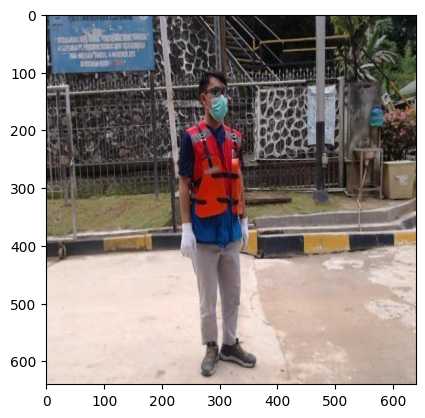

In [3]:
# Example of loading and visualizing an image from the dataset

img = cv2.imread("/content/ML-31005-6/train/images/image_249_jpg.rf.f6f3397ad39cae6ac5fe59f3969aada1.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


### Data remapping
Before using the data imported from roboflow we must remap the yaml files to ensure the paths for the data follows the collab environment format

In [4]:
# Define the path where Roboflow data is downloaded
dataset_dir = '/content/ML-31005-6'  # This should be the directory where the dataset is downloaded

# Path to your YAML file
yaml_path = '/content/ML-31005-6/data.yaml'  # Update with your file path

# Update YAML file paths for train, val, and test images
with open(yaml_path, 'r') as file:
    yaml_content = file.read()

# Replace the train, val, and test paths dynamically with the correct dataset path
yaml_content = yaml_content.replace('ML-31005-6/train/images', f'{dataset_dir}/train/images')
yaml_content = yaml_content.replace('ML-31005-6/valid/images', f'{dataset_dir}/valid/images')
yaml_content = yaml_content.replace('../test/images', f'{dataset_dir}/test/images')

# Write the updated YAML content back to the file
with open(yaml_path, 'w') as file:
    file.write(yaml_content)

print(f'YAML file paths updated successfully at {yaml_path}')

YAML file paths updated successfully at /content/ML-31005-6/data.yaml


## Step 3: Inital Model Training and Testing using Pretrained Yolov5


### Model Selection
We use YOLOv5 as it is optimized for real-time object detection, making it suitable for future video footage analysis.

### Pretrained Model
For inital exploration and validation, I have chosen to use a pretrained model to see what kind of information is gained from the inital test



In [4]:
# Load the YOLOv5 Repo
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 16982, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 16982 (delta 90), reused 108 (delta 53), pack-reused 16805 (from 1)
Receiving objects: 100% (16982/16982), 15.72 MiB | 28.04 MiB/s, done.
Resolving deltas: 100% (11623/11623), done.


In [10]:

!python /content/yolov5/train.py --img 640 --batch 16 --epochs 30 --data /content/ML-31005-4/data.yaml --weights yolov5s.pt # Training using existing model


2024-10-12 03:45:04.169803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 03:45:04.191327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 03:45:04.198064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/ML-31005-1/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=60, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_sc

Discussion;


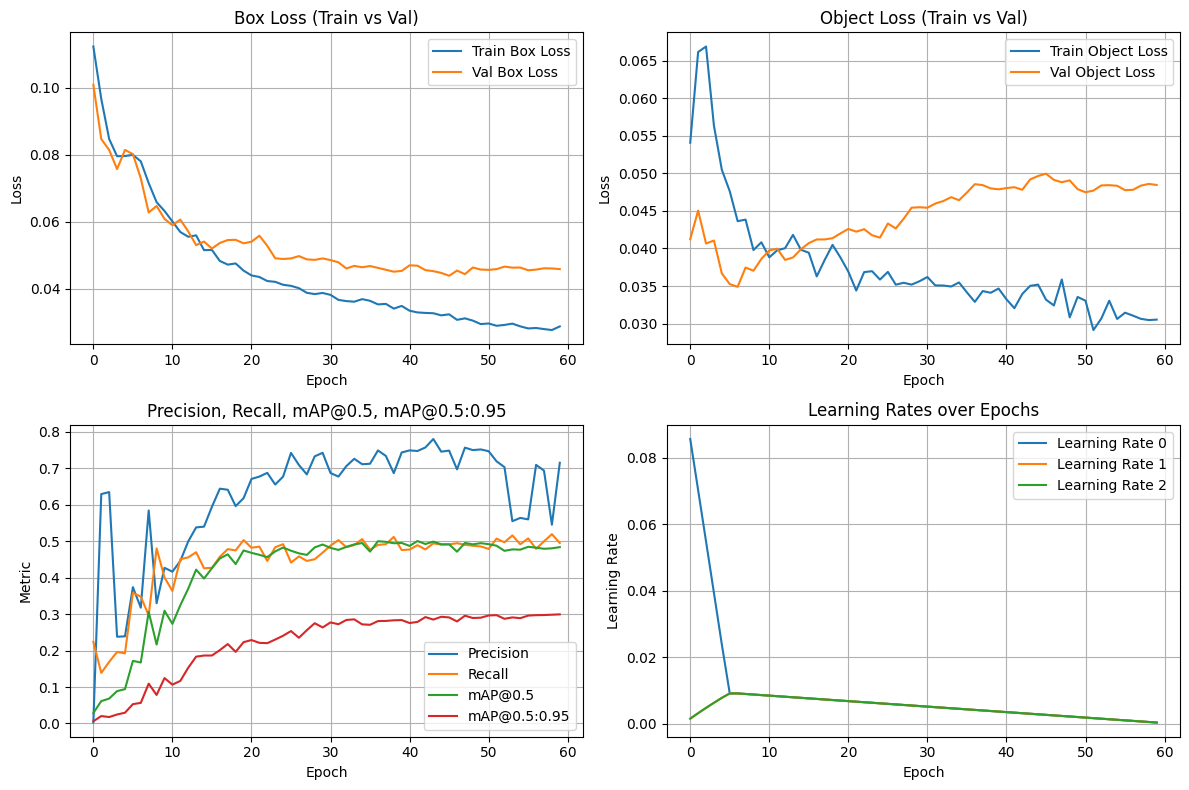

In [13]:
# Load the training results
results_path = '/content/yolov5/runs/train/exp4/results.csv'
results = pd.read_csv(results_path)

results.columns = results.columns.str.strip()  # Remove extra spaces in column names

# Plot all relevant statistics
plt.figure(figsize=(12, 8))

# Subplot 1: Training and validation box loss
plt.subplot(2, 2, 1)
plt.plot(results['epoch'], results['train/box_loss'], label='Train Box Loss')
plt.plot(results['epoch'], results['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Box Loss (Train vs Val)')
plt.legend()
plt.grid(True)

# Subplot 2: Training and validation object loss
plt.subplot(2, 2, 2)
plt.plot(results['epoch'], results['train/obj_loss'], label='Train Object Loss')
plt.plot(results['epoch'], results['val/obj_loss'], label='Val Object Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Object Loss (Train vs Val)')
plt.legend()
plt.grid(True)

# Subplot 3: Metrics - Precision, Recall, mAP@0.5, and mAP@0.5:0.95
plt.subplot(2, 2, 3)
plt.plot(results['epoch'], results['metrics/precision'], label='Precision')
plt.plot(results['epoch'], results['metrics/recall'], label='Recall')
plt.plot(results['epoch'], results['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(results['epoch'], results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Precision, Recall, mAP@0.5, mAP@0.5:0.95')
plt.legend()
plt.grid(True)

# Subplot 4: Learning rates over epochs
plt.subplot(2, 2, 4)
plt.plot(results['epoch'], results['x/lr0'], label='Learning Rate 0')
plt.plot(results['epoch'], results['x/lr1'], label='Learning Rate 1')
plt.plot(results['epoch'], results['x/lr2'], label='Learning Rate 2')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rates over Epochs')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


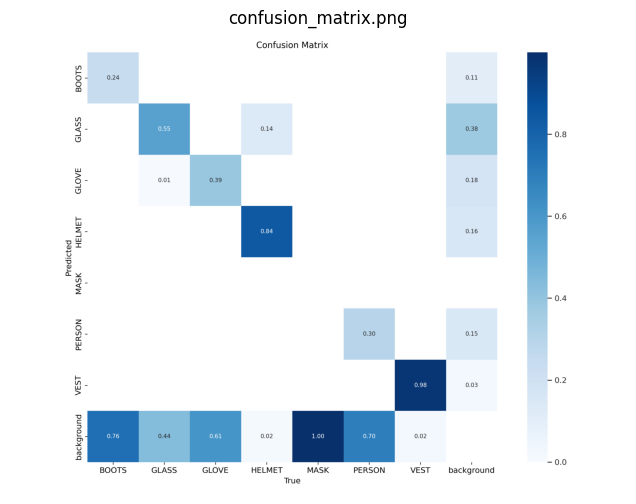

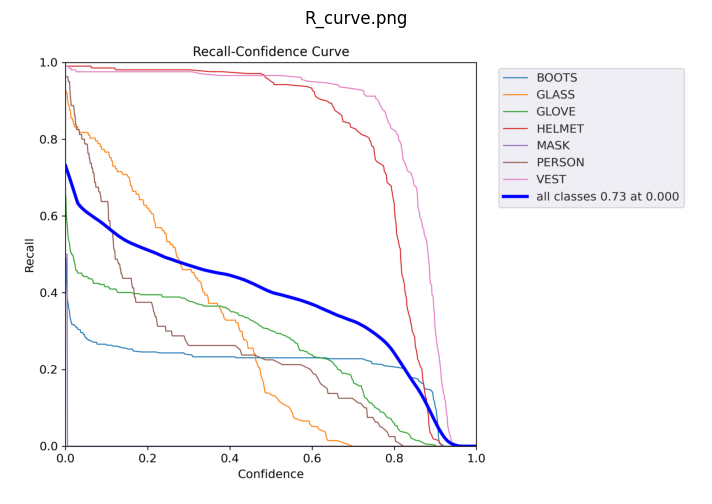

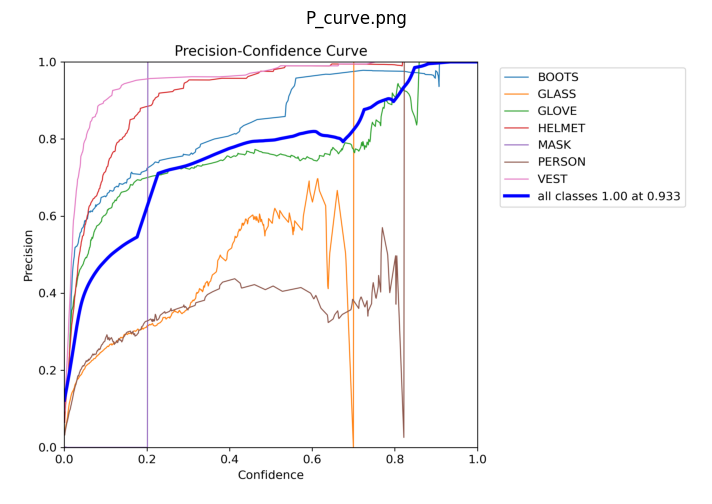

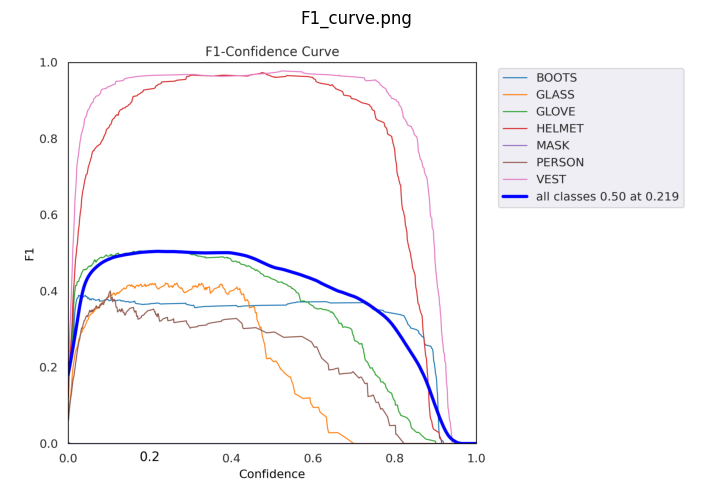

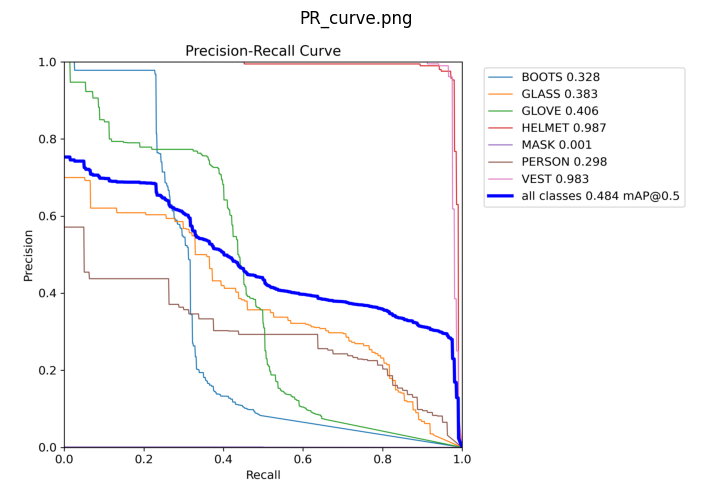

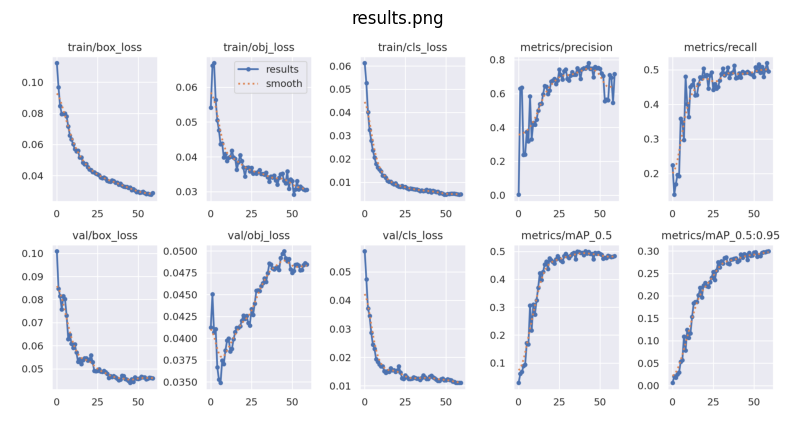

In [18]:
import os

# Directory where YOLOv5 saves the result images
results_dir = '/content/yolov5/runs/train/exp4'

# List all PNG files in the results directory
png_files = [f for f in os.listdir(results_dir) if f.endswith('.png')]

# Display all PNG files
for png_file in png_files:
    img_path = os.path.join(results_dir, png_file)
    img = Image.open(img_path)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(png_file)
    plt.show()

## Step 4: Final Model Training using custom Yolov5 with no weights


### Model Architecture
The model architecture is retrieved from the github project. The github project contains multiple different architectures and configurations thats were developed during model testing and evaluation

### Current Architecture
Custom Backbone
backbone:

  [from, number, module, args]
  
    [-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
    [-1, 5, C3, [128]],  # increase depth of C3 at P2 to capture more small-object features
    [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
    [-1, 8, C3, [256]],  # increased depth of C3 at P3 to capture more medium object features
    [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
    [-1, 9, C3, [512]],  # retain depth at P4
    [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
    [-1, 3, C3, [1024]],  # retain depth at P5
    [-1, 1, SPPF, [1024, 5]],  # Spatial Pyramid Pooling (efficient feature aggregation)
  

Custom Model Head
head:

    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 4, C3, [512, False]],  # increase depth for small objects (better small-object detection)

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3 (small object detection)
    [-1, 4, C3, [256, False]],  # emphasize small objects

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, C3, [512, False]],  # standard medium object detection (P4/16)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, C3, [1024, False]],  # standard large object detection (P5/32)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  

### Command inputs:


In [ ]:
!python /content/yolov5/train.py --img 640 --batch 64 --epochs 600 --data /content/ML-31005-6/data.yaml --cfg /content/PPE-Yolov5/yolo5ppel.yaml --weights '' --cache  # Training from scratch using the yolov5s as a baseline


### Saving to Google Drive
To save the results of the training we can utalise the following script

In [ ]:

# Define the source path (entire experiment folder)
exp_folder_path = '/content/yolov5/runs/train/exp'  # Adjust 'exp' if multiple trainings have been run in the same session

# Destination path (Google Drive folder with timestamp)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
destination = f'/content/drive/MyDrive/31005/exp_{timestamp}'

# Copy the entire folder to Google Drive
shutil.copytree(exp_folder_path, destination)

print(f"Full exp folder saved to {destination}")

## Step 5: Model Evaluation

### Training Metrics
This section is used to display evaluation metrics as recorded during the training

In [ ]:
# Load the training results, this can be changed if using google drive
results_path = '/content/yolov5/runs/train/exp/results.csv'
#results_path = '/content/drive/MyDrive/31005/exp_{version}/results.csv'
results = pd.read_csv(results_path)

results.columns = results.columns.str.strip()  # Remove extra spaces in column names

# Plot all relevant statistics
plt.figure(figsize=(12, 8))

# Subplot 1: Training and validation box loss
plt.subplot(2, 2, 1)
plt.plot(results['epoch'], results['train/box_loss'], label='Train Box Loss')
plt.plot(results['epoch'], results['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Box Loss (Train vs Val)')
plt.legend()
plt.grid(True)

# Subplot 2: Training and validation object loss
plt.subplot(2, 2, 2)
plt.plot(results['epoch'], results['train/obj_loss'], label='Train Object Loss')
plt.plot(results['epoch'], results['val/obj_loss'], label='Val Object Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Object Loss (Train vs Val)')
plt.legend()
plt.grid(True)

# Subplot 3: Metrics - Precision, Recall, mAP@0.5, and mAP@0.5:0.95
plt.subplot(2, 2, 3)
plt.plot(results['epoch'], results['metrics/precision'], label='Precision')
plt.plot(results['epoch'], results['metrics/recall'], label='Recall')
plt.plot(results['epoch'], results['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(results['epoch'], results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Precision, Recall, mAP@0.5, mAP@0.5:0.95')
plt.legend()
plt.grid(True)

# Subplot 4: Learning rates over epochs
plt.subplot(2, 2, 4)
plt.plot(results['epoch'], results['x/lr0'], label='Learning Rate 0')
plt.plot(results['epoch'], results['x/lr1'], label='Learning Rate 1')
plt.plot(results['epoch'], results['x/lr2'], label='Learning Rate 2')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rates over Epochs')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Displaying Training Results
Displaying YOLOv5 result images by loading and showing all PNG files from the specified results directory.







In [ ]:
# Directory where YOLOv5 saves the result images
results_dir = '/content/yolov5/runs/train/exp'

# Can also use the google drive path
#results_dir = '/content/drive/MyDrive/31005/exp_{version}'

# List all PNG files in the results directory
png_files = [f for f in os.listdir(results_dir) if f.endswith('.png')]

# Display all PNG files
for png_file in png_files:
    img_path = os.path.join(results_dir, png_file)
    img = Image.open(img_path)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(png_file)
    plt.show()

## Step 6: Model Validation

### Validation on internet images
We can then test the custom trained model on live data taken from the internet/any other source and test it. Images can be of any input size.

*Note a google drive connection is required for the test images but other images can be used for validation

In [ ]:
# Step 1: Specify the path to the trained model and test images
# best weight - exp_bigBigBatch_20241013-063732
trained_model_path = '/content/drive/MyDrive/31005/exp_bigBigBatch_20241013-063732/weights/best.pt'  # Path to trained model
test_images_path = '/content/drive/MyDrive/31005/test_images'  # Path to your test images folder
output_path = '/content/drive/MyDrive/31005/test_output_example'  # Where the detection results will be saved

# Step 2: Run YOLOv5 detection, specifying the image size (e.g., 640)
!python /content/yolov5/detect.py --weights {trained_model_path} --img 640 --conf 0.25 --source {test_images_path} --save-txt --save-conf --project {output_path} --name test_output

# Step 3: Visualize the output images (same as the previous step)
import matplotlib.pyplot as plt
import cv2
import glob

# Get the output images
image_paths = glob.glob(f'{output_path}/test_output/*.jpg')

# Plot the detected images
for img_path in image_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## Step 7: PPE Compliance Checker
This section defines a process for reading  detection results, converting detection coordinates to bounding box format, checking if people are compliant with required PPE, and displaying both bounding box results and compliance status on the image and terminal.







In [ ]:
#The following code can be used to adjust which images are used for analysis

# Path to a test output folder (images and txt files)
output_images_path = '/content/drive/MyDrive/31005/test_output/test_output/*.jpg'
output_txt_path = '/content/drive/MyDrive/31005/test_output/test_output/labels/*.txt'

# Required PPE (modify based on which PPE is required - manual user input)
required_ppe = ['HELMET', 'VEST']

In [ ]:
# Function to read detection results from a saved YOLOv5 txt file
def read_detections(txt_file_path):
    columns = ['class', 'x_center', 'y_center', 'width', 'height', 'confidence']
    try:
        df = pd.read_csv(txt_file_path, sep='\s+', header=None, names=columns)
        return df
    except Exception as e:
        print(f"Error reading {txt_file_path}: {e}")
        return pd.DataFrame()  # Return empty DataFrame if reading fails

# Function to convert YOLO format to bounding box format (xmin, ymin, xmax, ymax)
def yolo_to_bbox(df, img_width, img_height):
    df['xmin'] = (df['x_center'] - df['width'] / 2) * img_width
    df['xmax'] = (df['x_center'] + df['width'] / 2) * img_width
    df['ymin'] = (df['y_center'] - df['height'] / 2) * img_height
    df['ymax'] = (df['y_center'] + df['height'] / 2) * img_height
    return df

# Correct Class Mapping based on your new detection order
class_names = {4: 'PERSON', 3: 'HELMET', 1: 'GLASS', 5: 'VEST'}

# Function to check if the center of an item falls within the bounding box of a person
def is_within_person(person_bbox, item_bbox):
    item_center_x = (item_bbox[0] + item_bbox[2]) / 2
    item_center_y = (item_bbox[1] + item_bbox[3]) / 2
    return person_bbox[0] <= item_center_x <= person_bbox[2] and person_bbox[1] <= item_center_y <= person_bbox[3]

# Function to check if a person is wearing the required PPE
def check_ppe(detections, required_ppe, img_width, img_height, confidence_threshold=0.2):
    detections = yolo_to_bbox(detections, img_width, img_height)  # Convert to bbox format
    detections = detections[detections['confidence'] >= confidence_threshold]  # Filter low-confidence detections

    # Mapping the PPE to their respective class IDs using the class_names dictionary
    ppe_class_ids = [key for key, value in class_names.items() if value in required_ppe]

    # Get the persons and PPE items from the detections
    people = detections[detections['class'] == 4]  # PERSON class is 4
    ppe_items = detections[detections['class'].isin(ppe_class_ids)]  # Filter by required PPE classes

    compliance = {}

    if people.empty:
        print("No person detected in the image.")

    for person_idx, person in people.iterrows():
        person_bbox = [person['xmin'], person['ymin'], person['xmax'], person['ymax']]
        compliance[person_idx] = {"compliant": True, "missing_ppe": []}

        for ppe in required_ppe:
            ppe_worn = False
            for _, item in ppe_items.iterrows():
                item_bbox = [item['xmin'], item['ymin'], item['xmax'], item['ymax']]

                # Check if the item's bounding box center falls within the person's bounding box
                if is_within_person(person_bbox, item_bbox):
                    ppe_worn = True
                    break

            if not ppe_worn:
                compliance[person_idx]["compliant"] = False
                compliance[person_idx]["missing_ppe"].append(ppe)

    return compliance

# Function to display the detection results and print to terminal
def display_results(image_path, detections, compliance):
    img = cv2.imread(image_path)
    img_height, img_width, _ = img.shape

    people = detections[detections['class'] == 4]  # PERSON class is 4

    if people.empty:
        print(f"No person detected in the image {image_path}")

    for person_idx, person in people.iterrows():
        person_bbox = [int(person['xmin']), int(person['ymin']), int(person['xmax']), int(person['ymax'])]
        color = (0, 255, 0) if compliance[person_idx]["compliant"] else (0, 0, 255)

        # Draw the person's bounding box
        cv2.rectangle(img, (person_bbox[0], person_bbox[1]), (person_bbox[2], person_bbox[3]), color, 2)

        # Add text indicating compliance status
        status_text = "Compliant" if compliance[person_idx]["compliant"] else f"Missing: {', '.join(compliance[person_idx]['missing_ppe'])}"
        cv2.putText(img, status_text, (person_bbox[0], person_bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        # Print compliance status to terminal
        if compliance[person_idx]["compliant"]:
            print(f"Person {person_idx}: Compliant with PPE requirements")
        else:
            print(f"Person {person_idx}: Missing PPE: {', '.join(compliance[person_idx]['missing_ppe'])}")

    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# Iterate through each output image and corresponding txt file
image_paths = glob.glob(output_images_path)
txt_paths = glob.glob(output_txt_path)

for img_path, txt_path in zip(image_paths, txt_paths):
    print(f"Processing {img_path}")

    # Load detections from txt file
    detections = read_detections(txt_path)

    if detections.empty:
        print(f"No detections in {txt_path}")
        continue

    img = cv2.imread(img_path)
    img_height, img_width, _ = img.shape

    # Check PPE compliance
    compliance = check_ppe(detections, required_ppe, img_width, img_height, confidence_threshold=0.2)

    # Display results with bounding boxes and compliance info
    display_results(img_path, detections, compliance)